# Flair NLP Framework

In [1]:
!pip install --upgrade flair==0.11.1
!pip install torch
!pip install importlib-metadata
!pip install emoji
!pip install nltk
!pip install sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 5.7 MB/s 
     |████████████████████████████████| 19.7 MB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 49.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.7 MB 44.1 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 981 kB 61.1 MB/s 
     |████████████████████████████████| 1.2 MB 56.9 MB/s 
     |████████████████████████████████| 48 kB 5.9 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 120 kB 51.4 MB/s 
     |████████████████████████████████| 788 kB 64.0 MB/s 
     |████████████████████████████████| 200 kB 71.1 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import joblib
from flair.data import Corpus, Sentence
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus, TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, TransformerDocumentEmbeddings, StackedEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from flair.hyperparameter.param_selection import SearchSpace, Parameter
from flair.hyperparameter.param_selection import TextClassifierParamSelector, OptimizationValue
from hyperopt import hp
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from typing import List

from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.optim.adam import Adam
torch.cuda.is_available()


Mounted at /content/drive


True

# Paths

In [3]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_train = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/train_tweet.csv"
path_test = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/test_tweet.csv"

path_flair = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/"
path_flair_train = path_flair+"train.csv"
path_flair_test = path_flair+"test.csv"
path_flair_dev = path_flair+"dev.csv"

path_model_distilbert = parent_path+"team project/codes/models/flair_models/twitter_distilbert_final"
path_model_distilroberta = parent_path+"team project/codes/models/flair_models/twitter_distilroberta_final"

# Data Exploration

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


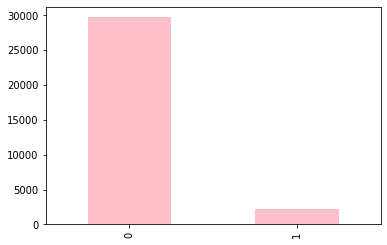

In [4]:
data = pd.read_csv(path_train)

data['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))
data.head()

# Fast text format and split Dataset

In [5]:
data['label'] = '__label__' + data['label'].astype(str)

train, test = train_test_split(data, test_size=0.2, random_state = 453, stratify=data['label'])
test, dev = train_test_split(test, test_size=0.5 , random_state = 453, stratify= test['label'])

train.to_csv(path_flair_train, sep='\t', index = False, header = False)
test.to_csv(path_flair_test, sep='\t', index = False, header = False)
dev.to_csv(path_flair_dev, sep='\t', index = False, header = False)

train.head(5)

,id,label,tweet
24478,24479,__label__0,let me guess... the bon voyage thing is on vli...
15737,15738,__label__0,@user had to go home today @user (named after...
67,68,__label__0,i'm sure they are just as happy.... ðð½ð...
9148,9149,__label__0,@user @user and i thought you were mad... /:
21246,21247,__label__0,this time next week i'd have finished work for...


# Train Classifier

## Distilbert

In [6]:
#1. get the corpus
column_name_map = {2: "text", 1: "label_topic"}
corpus: Corpus = CSVClassificationCorpus(path_flair,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter='\t',   # tab-separated files
                                         label_type= "label")
print(corpus)

#2. what label do we want to predict?
label_type = 'label'

# 3. create the label dictionary
label_dict = corpus.make_label_dictionary(label_type=label_type)

# 4. initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, label_type=label_type)

# 6. initialize trainer
trainer = ModelTrainer(classifier, corpus)

2022-08-24 15:17:48,563 Reading data from /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape
2022-08-24 15:17:48,566 Train: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/train.csv
2022-08-24 15:17:48,567 Dev: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/dev.csv
2022-08-24 15:17:48,569 Test: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/test.csv
Corpus: 25568 train + 3196 dev + 3195 test sentences
2022-08-24 15:17:48,824 Computing label dictionary. Progress:


25568it [00:19, 1317.87it/s]

2022-08-24 15:18:08,297 Dictionary created for label 'label' with 3 values: __label__0 (seen 23774 times), __label__1 (seen 1794 times)


In [7]:
# 7. run training with fine-tuning
trainer.fine_tune(path_model_distilbert,
                  learning_rate=5.0e-5,
                  mini_batch_size=4,
                  max_epochs=7,
                  write_weights = True, #maybe
                  )


2022-08-24 15:18:26,037 ----------------------------------------------------------------------------------------------------
2022-08-24 15:18:26,044 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_featur

100%|██████████| 799/799 [00:07<00:00, 99.88it/s]


2022-08-24 15:24:35,194 Evaluating as a multi-label problem: False
2022-08-24 15:24:35,224 DEV : loss 0.02985415607690811 - f1-score (micro avg)  0.9621
2022-08-24 15:24:36,481 BAD EPOCHS (no improvement): 4
2022-08-24 15:24:36,489 ----------------------------------------------------------------------------------------------------
2022-08-24 15:25:09,489 epoch 2 - iter 639/6392 - loss 0.01921560 - samples/sec: 79.50 - lr: 0.000047
2022-08-24 15:25:45,320 epoch 2 - iter 1278/6392 - loss 0.01884656 - samples/sec: 79.47 - lr: 0.000046
2022-08-24 15:26:21,191 epoch 2 - iter 1917/6392 - loss 0.01929581 - samples/sec: 79.63 - lr: 0.000045
2022-08-24 15:26:56,953 epoch 2 - iter 2556/6392 - loss 0.01983383 - samples/sec: 79.57 - lr: 0.000044
2022-08-24 15:27:32,699 epoch 2 - iter 3195/6392 - loss 0.02036261 - samples/sec: 79.66 - lr: 0.000044
2022-08-24 15:28:08,439 epoch 2 - iter 3834/6392 - loss 0.02139441 - samples/sec: 79.74 - lr: 0.000043
2022-08-24 15:28:44,238 epoch 2 - iter 4473/6392 -

100%|██████████| 799/799 [00:07<00:00, 101.06it/s]

2022-08-24 15:30:42,437 Evaluating as a multi-label problem: False
2022-08-24 15:30:42,462 DEV : loss 0.030110256746411324 - f1-score (micro avg)  0.9703


2022-08-24 15:30:43,739 BAD EPOCHS (no improvement): 4
2022-08-24 15:30:43,747 ----------------------------------------------------------------------------------------------------
2022-08-24 15:31:16,698 epoch 3 - iter 639/6392 - loss 0.00908941 - samples/sec: 79.64 - lr: 0.000039
2022-08-24 15:31:56,884 epoch 3 - iter 1278/6392 - loss 0.00940465 - samples/sec: 70.65 - lr: 0.000038
2022-08-24 15:32:32,578 epoch 3 - iter 1917/6392 - loss 0.01043897 - samples/sec: 79.79 - lr: 0.000037
2022-08-24 15:33:08,225 epoch 3 - iter 2556/6392 - loss 0.01016084 - samples/sec: 79.84 - lr: 0.000037
2022-08-24 15:33:44,234 epoch 3 - iter 3195/6392 - loss 0.01059850 - samples/sec: 79.05 - lr: 0.000036
2022-08-24 15:34:20,243 epoch 3 - iter 3834/6392 - loss 0.01070917 - samples/sec: 79.73 - lr: 0.000035
2022-08-24 15:34:55,760 epoch 3 - iter 4473/6392 - loss 0.01088496 - samples/sec: 80.13 - lr: 0.000034
2022-08-24 15:35:31,823 epoch 3 - iter 5112/6392 - loss 0.01101463 - samples/sec: 78.87 - lr: 0.0000

100%|██████████| 799/799 [00:07<00:00, 103.26it/s]

2022-08-24 15:36:54,045 Evaluating as a multi-label problem: False
2022-08-24 15:36:54,078 DEV : loss 0.0541364848613739 - f1-score (micro avg)  0.964


2022-08-24 15:36:55,335 BAD EPOCHS (no improvement): 4
2022-08-24 15:36:55,343 ----------------------------------------------------------------------------------------------------
2022-08-24 15:37:28,528 epoch 4 - iter 639/6392 - loss 0.00559351 - samples/sec: 79.18 - lr: 0.000031
2022-08-24 15:38:04,210 epoch 4 - iter 1278/6392 - loss 0.00528681 - samples/sec: 79.80 - lr: 0.000030
2022-08-24 15:38:40,160 epoch 4 - iter 1917/6392 - loss 0.00572213 - samples/sec: 79.86 - lr: 0.000029
2022-08-24 15:39:15,768 epoch 4 - iter 2556/6392 - loss 0.00554864 - samples/sec: 79.86 - lr: 0.000029
2022-08-24 15:39:51,376 epoch 4 - iter 3195/6392 - loss 0.00505113 - samples/sec: 79.90 - lr: 0.000028
2022-08-24 15:40:26,989 epoch 4 - iter 3834/6392 - loss 0.00497842 - samples/sec: 79.85 - lr: 0.000027
2022-08-24 15:41:02,577 epoch 4 - iter 4473/6392 - loss 0.00475610 - samples/sec: 79.92 - lr: 0.000026
2022-08-24 15:41:38,261 epoch 4 - iter 5112/6392 - loss 0.00456875 - samples/sec: 79.75 - lr: 0.0000

100%|██████████| 799/799 [00:07<00:00, 102.32it/s]

2022-08-24 15:43:00,334 Evaluating as a multi-label problem: False
2022-08-24 15:43:00,360 DEV : loss 0.04010745882987976 - f1-score (micro avg)  0.9684


2022-08-24 15:43:01,888 BAD EPOCHS (no improvement): 4
2022-08-24 15:43:01,895 ----------------------------------------------------------------------------------------------------
2022-08-24 15:43:34,678 epoch 5 - iter 639/6392 - loss 0.00326604 - samples/sec: 80.00 - lr: 0.000023
2022-08-24 15:44:10,414 epoch 5 - iter 1278/6392 - loss 0.00206430 - samples/sec: 79.62 - lr: 0.000022
2022-08-24 15:44:45,994 epoch 5 - iter 1917/6392 - loss 0.00181289 - samples/sec: 80.02 - lr: 0.000021
2022-08-24 15:45:21,574 epoch 5 - iter 2556/6392 - loss 0.00196810 - samples/sec: 79.94 - lr: 0.000021
2022-08-24 15:45:57,196 epoch 5 - iter 3195/6392 - loss 0.00188813 - samples/sec: 79.90 - lr: 0.000020
2022-08-24 15:46:32,801 epoch 5 - iter 3834/6392 - loss 0.00250208 - samples/sec: 79.86 - lr: 0.000019
2022-08-24 15:47:08,337 epoch 5 - iter 4473/6392 - loss 0.00244114 - samples/sec: 80.00 - lr: 0.000018
2022-08-24 15:47:43,940 epoch 5 - iter 5112/6392 - loss 0.00239488 - samples/sec: 79.91 - lr: 0.0000

100%|██████████| 799/799 [00:07<00:00, 102.04it/s]

2022-08-24 15:49:06,025 Evaluating as a multi-label problem: False
2022-08-24 15:49:06,052 DEV : loss 0.05092249810695648 - f1-score (micro avg)  0.97


2022-08-24 15:49:07,650 BAD EPOCHS (no improvement): 4
2022-08-24 15:49:07,657 ----------------------------------------------------------------------------------------------------
2022-08-24 15:49:40,463 epoch 6 - iter 639/6392 - loss 0.00089662 - samples/sec: 79.98 - lr: 0.000015
2022-08-24 15:50:16,138 epoch 6 - iter 1278/6392 - loss 0.00057386 - samples/sec: 79.72 - lr: 0.000014
2022-08-24 15:50:51,706 epoch 6 - iter 1917/6392 - loss 0.00040952 - samples/sec: 79.94 - lr: 0.000013
2022-08-24 15:51:27,242 epoch 6 - iter 2556/6392 - loss 0.00052408 - samples/sec: 79.98 - lr: 0.000013
2022-08-24 15:52:02,823 epoch 6 - iter 3195/6392 - loss 0.00063940 - samples/sec: 80.18 - lr: 0.000012
2022-08-24 15:52:38,349 epoch 6 - iter 3834/6392 - loss 0.00075205 - samples/sec: 80.12 - lr: 0.000011
2022-08-24 15:53:13,823 epoch 6 - iter 4473/6392 - loss 0.00073259 - samples/sec: 80.13 - lr: 0.000010
2022-08-24 15:53:49,360 epoch 6 - iter 5112/6392 - loss 0.00070626 - samples/sec: 80.11 - lr: 0.0000

100%|██████████| 799/799 [00:08<00:00, 97.56it/s] 

2022-08-24 15:55:11,439 Evaluating as a multi-label problem: False
2022-08-24 15:55:11,471 DEV : loss 0.07853363454341888 - f1-score (micro avg)  0.9687


2022-08-24 15:55:12,762 BAD EPOCHS (no improvement): 4
2022-08-24 15:55:12,767 ----------------------------------------------------------------------------------------------------
2022-08-24 15:55:45,534 epoch 7 - iter 639/6392 - loss 0.00079608 - samples/sec: 80.02 - lr: 0.000007
2022-08-24 15:56:21,075 epoch 7 - iter 1278/6392 - loss 0.00040760 - samples/sec: 79.98 - lr: 0.000006
2022-08-24 15:56:56,774 epoch 7 - iter 1917/6392 - loss 0.00031944 - samples/sec: 79.70 - lr: 0.000006
2022-08-24 15:57:32,236 epoch 7 - iter 2556/6392 - loss 0.00031486 - samples/sec: 80.12 - lr: 0.000005
2022-08-24 15:58:07,798 epoch 7 - iter 3195/6392 - loss 0.00025748 - samples/sec: 80.04 - lr: 0.000004
2022-08-24 15:58:43,179 epoch 7 - iter 3834/6392 - loss 0.00026017 - samples/sec: 80.30 - lr: 0.000003
2022-08-24 15:59:18,682 epoch 7 - iter 4473/6392 - loss 0.00022385 - samples/sec: 80.14 - lr: 0.000002
2022-08-24 15:59:54,142 epoch 7 - iter 5112/6392 - loss 0.00019652 - samples/sec: 80.25 - lr: 0.0000

100%|██████████| 799/799 [00:08<00:00, 95.90it/s]

2022-08-24 16:01:16,868 Evaluating as a multi-label problem: False
2022-08-24 16:01:16,898 DEV : loss 0.09650412946939468 - f1-score (micro avg)  0.9681


2022-08-24 16:01:18,163 BAD EPOCHS (no improvement): 4
2022-08-24 16:01:26,136 ----------------------------------------------------------------------------------------------------
2022-08-24 16:01:26,143 Testing using last state of model ...


100%|██████████| 799/799 [00:08<00:00, 98.79it/s]


2022-08-24 16:01:34,757 Evaluating as a multi-label problem: False
2022-08-24 16:01:34,785 0.9671	0.9671	0.9671	0.9671
2022-08-24 16:01:34,789 
Results:
- F-score (micro) 0.9671
- F-score (macro) 0.8603
- Accuracy 0.9671

By class:
              precision    recall  f1-score   support

  __label__0     0.9748    0.9902    0.9825      2971
  __label__1     0.8362    0.6607    0.7382       224

    accuracy                         0.9671      3195
   macro avg     0.9055    0.8255    0.8603      3195
weighted avg     0.9651    0.9671    0.9653      3195

2022-08-24 16:01:34,795 ----------------------------------------------------------------------------------------------------


{'test_score': 0.9671361502347418,
 'dev_score_history': [0.9621401752190237,
  0.9702753441802253,
  0.964017521902378,
  0.968397997496871,
  0.9699624530663329,
  0.9687108886107635,
  0.9680851063829787],
 'train_loss_history': [0.04447450730889319,
  0.021471032502296844,
  0.010690561243541737,
  0.004583313633184784,
  0.0024627126274314706,
  0.0007042456483282268,
  0.00015817030737613264],
 'dev_loss_history': [0.02985415607690811,
  0.030110256746411324,
  0.0541364848613739,
  0.04010745882987976,
  0.05092249810695648,
  0.07853363454341888,
  0.09650412946939468]}

2022-08-24 16:01:34,823 ----------------------------------------------------------------------------------------------------
2022-08-24 16:01:34,824 WARNING: No LOSS found for test split in this data.
2022-08-24 16:01:34,827 Are you sure you want to plot LOSS and not another value?
2022-08-24 16:01:34,829 ----------------------------------------------------------------------------------------------------
2022-08-24 16:01:34,852 ----------------------------------------------------------------------------------------------------
2022-08-24 16:01:34,855 WARNING: No F1 found for test split in this data.
2022-08-24 16:01:34,856 Are you sure you want to plot F1 and not another value?
2022-08-24 16:01:34,861 ----------------------------------------------------------------------------------------------------
2022-08-24 16:01:37,634 Loss and F1 plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/twitter_distilbert_final/training.png


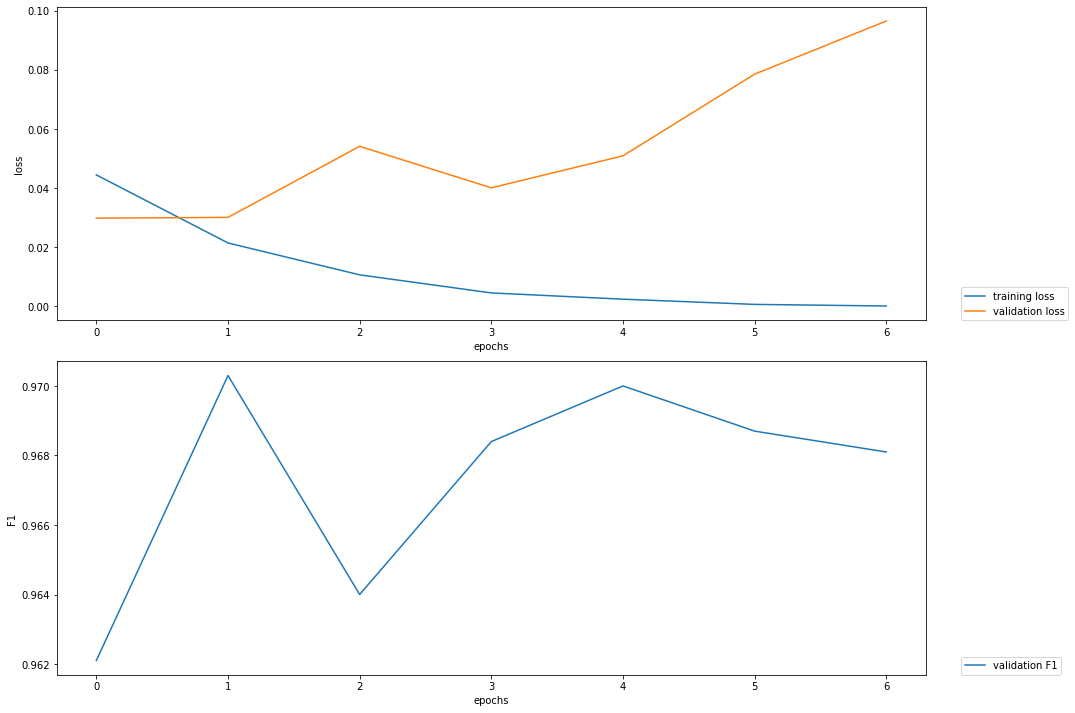

2022-08-24 16:01:57,834 Weights plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/twitter_distilbert_final/weights.png


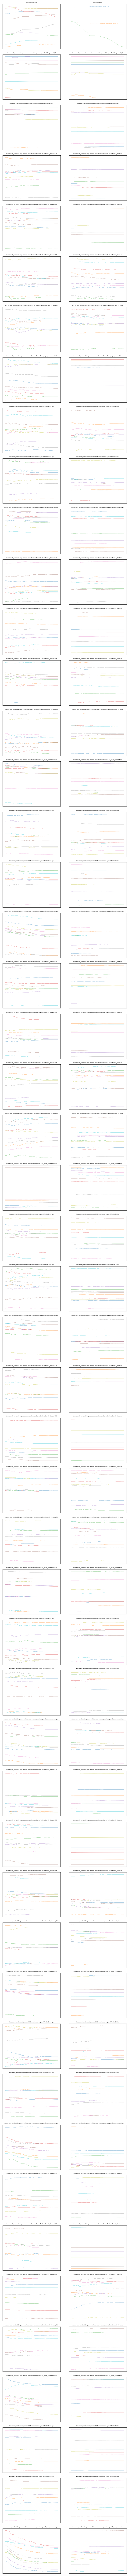

In [8]:
# visualize
plotter = Plotter()
plotter.plot_training_curves(path_model_distilbert+'/loss.tsv')
plotter.plot_weights(path_model_distilbert+'/weights.txt')

In [9]:
new_clf = TextClassifier.load(path_model_distilbert+'/final-model.pt')

2022-08-24 16:02:01,533 loading file /content/drive/My Drive/team project/codes/models/flair_models/twitter_distilbert_final/final-model.pt


In [10]:
pred1 = Sentence("That girl is stupid")
pred2 = Sentence("This is a good material")

In [11]:
new_clf.predict(pred1)

In [12]:
pred1

Sentence: "That girl is stupid" → __label__1 (0.9996)

In [13]:
pred1.labels[0].to_dict()['value'] 

'__label__1'

## Distilroberta

In [15]:
#1. get the corpus
column_name_map = {2: "text", 1: "label_topic"}
corpus: Corpus = CSVClassificationCorpus(path_flair,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter='\t',   # tab-separated files
                                         label_type= "label")
print(corpus)

#2. what label do we want to predict?
label_type = 'label'

# 3. create the label dictionary
label_dict = corpus.make_label_dictionary(label_type=label_type)

# 4. initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('distilroberta-base', fine_tune=True)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, label_type=label_type)

# 6. initialize trainer
trainer = ModelTrainer(classifier, corpus)

2022-08-24 16:10:10,144 Reading data from /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape
2022-08-24 16:10:10,147 Train: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/train.csv
2022-08-24 16:10:10,149 Dev: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/dev.csv
2022-08-24 16:10:10,150 Test: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/test.csv
Corpus: 25568 train + 3196 dev + 3195 test sentences
2022-08-24 16:10:10,261 Computing label dictionary. Progress:


25568it [00:08, 2853.42it/s]

2022-08-24 16:10:19,229 Dictionary created for label 'label' with 3 values: __label__0 (seen 23774 times), __label__1 (seen 1794 times)


In [16]:
# 7. run training with fine-tuning
trainer.fine_tune(path_model_distilroberta,
                  learning_rate=5.0e-5,
                  mini_batch_size=4,
                  max_epochs=7,
                  write_weights = True, #maybe
                  )


2022-08-24 16:10:25,956 ----------------------------------------------------------------------------------------------------
2022-08-24 16:10:25,963 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAt

100%|██████████| 799/799 [00:08<00:00, 97.21it/s]


2022-08-24 16:17:32,477 Evaluating as a multi-label problem: False
2022-08-24 16:17:32,507 DEV : loss 0.039952464401721954 - f1-score (micro avg)  0.9556
2022-08-24 16:17:33,772 BAD EPOCHS (no improvement): 4
2022-08-24 16:17:33,781 ----------------------------------------------------------------------------------------------------
2022-08-24 16:18:12,500 epoch 2 - iter 639/6392 - loss 0.03033942 - samples/sec: 67.50 - lr: 0.000047
2022-08-24 16:18:54,004 epoch 2 - iter 1278/6392 - loss 0.03308489 - samples/sec: 67.55 - lr: 0.000046
2022-08-24 16:19:36,148 epoch 2 - iter 1917/6392 - loss 0.03441460 - samples/sec: 67.00 - lr: 0.000045
2022-08-24 16:20:17,774 epoch 2 - iter 2556/6392 - loss 0.03239938 - samples/sec: 67.40 - lr: 0.000044
2022-08-24 16:20:59,471 epoch 2 - iter 3195/6392 - loss 0.03248058 - samples/sec: 67.28 - lr: 0.000044
2022-08-24 16:21:41,307 epoch 2 - iter 3834/6392 - loss 0.03235975 - samples/sec: 67.01 - lr: 0.000043
2022-08-24 16:22:22,792 epoch 2 - iter 4473/6392 

100%|██████████| 799/799 [00:08<00:00, 95.10it/s]

2022-08-24 16:24:39,407 Evaluating as a multi-label problem: False


2022-08-24 16:24:39,438 DEV : loss 0.037305090576410294 - f1-score (micro avg)  0.9603
2022-08-24 16:24:40,996 BAD EPOCHS (no improvement): 4
2022-08-24 16:24:41,002 ----------------------------------------------------------------------------------------------------
2022-08-24 16:25:20,407 epoch 3 - iter 639/6392 - loss 0.02115987 - samples/sec: 66.39 - lr: 0.000039
2022-08-24 16:26:02,360 epoch 3 - iter 1278/6392 - loss 0.02298078 - samples/sec: 66.90 - lr: 0.000038
2022-08-24 16:26:44,193 epoch 3 - iter 1917/6392 - loss 0.02355774 - samples/sec: 67.02 - lr: 0.000037
2022-08-24 16:27:25,744 epoch 3 - iter 2556/6392 - loss 0.02365905 - samples/sec: 67.59 - lr: 0.000037
2022-08-24 16:28:07,279 epoch 3 - iter 3195/6392 - loss 0.02305039 - samples/sec: 67.49 - lr: 0.000036
2022-08-24 16:28:48,902 epoch 3 - iter 3834/6392 - loss 0.02345621 - samples/sec: 67.38 - lr: 0.000035
2022-08-24 16:29:30,360 epoch 3 - iter 4473/6392 - loss 0.02286985 - samples/sec: 67.68 - lr: 0.000034
2022-08-24 16

100%|██████████| 799/799 [00:08<00:00, 99.68it/s]

2022-08-24 16:31:46,537 Evaluating as a multi-label problem: False
2022-08-24 16:31:46,571 DEV : loss 0.033054981380701065 - f1-score (micro avg)  0.9615


2022-08-24 16:31:48,188 BAD EPOCHS (no improvement): 4
2022-08-24 16:31:48,194 ----------------------------------------------------------------------------------------------------
2022-08-24 16:32:27,284 epoch 4 - iter 639/6392 - loss 0.02135005 - samples/sec: 66.82 - lr: 0.000031
2022-08-24 16:33:08,909 epoch 4 - iter 1278/6392 - loss 0.01866474 - samples/sec: 67.35 - lr: 0.000030
2022-08-24 16:33:50,337 epoch 4 - iter 1917/6392 - loss 0.01694898 - samples/sec: 67.70 - lr: 0.000029
2022-08-24 16:34:31,761 epoch 4 - iter 2556/6392 - loss 0.01573668 - samples/sec: 67.72 - lr: 0.000029
2022-08-24 16:35:13,396 epoch 4 - iter 3195/6392 - loss 0.01539962 - samples/sec: 67.31 - lr: 0.000028
2022-08-24 16:35:55,083 epoch 4 - iter 3834/6392 - loss 0.01550579 - samples/sec: 67.29 - lr: 0.000027
2022-08-24 16:36:36,565 epoch 4 - iter 4473/6392 - loss 0.01543796 - samples/sec: 67.63 - lr: 0.000026
2022-08-24 16:37:18,092 epoch 4 - iter 5112/6392 - loss 0.01530958 - samples/sec: 67.48 - lr: 0.0000

100%|██████████| 799/799 [00:07<00:00, 100.01it/s]

2022-08-24 16:38:52,632 Evaluating as a multi-label problem: False
2022-08-24 16:38:52,658 DEV : loss 0.0372510701417923 - f1-score (micro avg)  0.9637


2022-08-24 16:38:54,055 BAD EPOCHS (no improvement): 4
2022-08-24 16:38:54,063 ----------------------------------------------------------------------------------------------------
2022-08-24 16:39:32,747 epoch 5 - iter 639/6392 - loss 0.01060179 - samples/sec: 67.98 - lr: 0.000023
2022-08-24 16:40:14,543 epoch 5 - iter 1278/6392 - loss 0.01201611 - samples/sec: 67.22 - lr: 0.000022
2022-08-24 16:40:56,347 epoch 5 - iter 1917/6392 - loss 0.01084628 - samples/sec: 67.09 - lr: 0.000021
2022-08-24 16:41:37,882 epoch 5 - iter 2556/6392 - loss 0.01179309 - samples/sec: 67.53 - lr: 0.000021
2022-08-24 16:42:19,361 epoch 5 - iter 3195/6392 - loss 0.01098693 - samples/sec: 67.60 - lr: 0.000020
2022-08-24 16:43:00,787 epoch 5 - iter 3834/6392 - loss 0.01096444 - samples/sec: 67.67 - lr: 0.000019
2022-08-24 16:43:42,284 epoch 5 - iter 4473/6392 - loss 0.01046403 - samples/sec: 67.53 - lr: 0.000018
2022-08-24 16:44:23,993 epoch 5 - iter 5112/6392 - loss 0.01056266 - samples/sec: 67.30 - lr: 0.0000

100%|██████████| 799/799 [00:08<00:00, 96.19it/s]


2022-08-24 16:45:58,395 Evaluating as a multi-label problem: False
2022-08-24 16:45:58,422 DEV : loss 0.04410200193524361 - f1-score (micro avg)  0.9656
2022-08-24 16:45:59,682 BAD EPOCHS (no improvement): 4
2022-08-24 16:45:59,690 ----------------------------------------------------------------------------------------------------
2022-08-24 16:46:39,250 epoch 6 - iter 639/6392 - loss 0.00794644 - samples/sec: 66.15 - lr: 0.000015
2022-08-24 16:47:21,220 epoch 6 - iter 1278/6392 - loss 0.00631590 - samples/sec: 66.81 - lr: 0.000014
2022-08-24 16:48:02,593 epoch 6 - iter 1917/6392 - loss 0.00749413 - samples/sec: 67.86 - lr: 0.000013
2022-08-24 16:48:44,102 epoch 6 - iter 2556/6392 - loss 0.00761734 - samples/sec: 67.55 - lr: 0.000013
2022-08-24 16:49:25,568 epoch 6 - iter 3195/6392 - loss 0.00721243 - samples/sec: 67.71 - lr: 0.000012
2022-08-24 16:50:07,144 epoch 6 - iter 3834/6392 - loss 0.00723969 - samples/sec: 67.47 - lr: 0.000011
2022-08-24 16:50:48,557 epoch 6 - iter 4473/6392 -

100%|██████████| 799/799 [00:07<00:00, 101.35it/s]

2022-08-24 16:53:04,332 Evaluating as a multi-label problem: False
2022-08-24 16:53:04,360 DEV : loss 0.04826454073190689 - f1-score (micro avg)  0.964


2022-08-24 16:53:05,616 BAD EPOCHS (no improvement): 4
2022-08-24 16:53:05,621 ----------------------------------------------------------------------------------------------------
2022-08-24 16:53:44,123 epoch 7 - iter 639/6392 - loss 0.00383282 - samples/sec: 67.87 - lr: 0.000007
2022-08-24 16:54:25,586 epoch 7 - iter 1278/6392 - loss 0.00523267 - samples/sec: 67.68 - lr: 0.000006
2022-08-24 16:55:07,155 epoch 7 - iter 1917/6392 - loss 0.00498825 - samples/sec: 67.47 - lr: 0.000006
2022-08-24 16:55:48,738 epoch 7 - iter 2556/6392 - loss 0.00415001 - samples/sec: 67.47 - lr: 0.000005
2022-08-24 16:56:30,204 epoch 7 - iter 3195/6392 - loss 0.00405124 - samples/sec: 67.67 - lr: 0.000004
2022-08-24 16:57:11,701 epoch 7 - iter 3834/6392 - loss 0.00427235 - samples/sec: 67.59 - lr: 0.000003
2022-08-24 16:57:53,245 epoch 7 - iter 4473/6392 - loss 0.00436423 - samples/sec: 67.46 - lr: 0.000002
2022-08-24 16:58:34,899 epoch 7 - iter 5112/6392 - loss 0.00453791 - samples/sec: 67.35 - lr: 0.0000

100%|██████████| 799/799 [00:08<00:00, 99.82it/s]

2022-08-24 17:00:09,504 Evaluating as a multi-label problem: False
2022-08-24 17:00:09,530 DEV : loss 0.04810949042439461 - f1-score (micro avg)  0.9659


2022-08-24 17:00:10,781 BAD EPOCHS (no improvement): 4
2022-08-24 17:00:14,863 ----------------------------------------------------------------------------------------------------
2022-08-24 17:00:14,870 Testing using last state of model ...


100%|██████████| 799/799 [00:09<00:00, 83.92it/s]


2022-08-24 17:00:24,823 Evaluating as a multi-label problem: False
2022-08-24 17:00:24,851 0.9659	0.9659	0.9659	0.9659
2022-08-24 17:00:24,855 
Results:
- F-score (micro) 0.9659
- F-score (macro) 0.8583
- Accuracy 0.9659

By class:
              precision    recall  f1-score   support

  __label__0     0.9757    0.9879    0.9818      2971
  __label__1     0.8075    0.6741    0.7348       224

    accuracy                         0.9659      3195
   macro avg     0.8916    0.8310    0.8583      3195
weighted avg     0.9639    0.9659    0.9645      3195

2022-08-24 17:00:24,859 ----------------------------------------------------------------------------------------------------


{'test_score': 0.9658841940532081,
 'dev_score_history': [0.9555694618272841,
  0.9602628285356696,
  0.9615143929912391,
  0.9637046307884856,
  0.9655819774718398,
  0.964017521902378,
  0.9658948685857321],
 'train_loss_history': [0.047585073241842836,
  0.03118668851496711,
  0.023309115438348314,
  0.015721195420002537,
  0.010326383426700935,
  0.0068886805147736,
  0.004215476082893236],
 'dev_loss_history': [0.039952464401721954,
  0.037305090576410294,
  0.033054981380701065,
  0.0372510701417923,
  0.04410200193524361,
  0.04826454073190689,
  0.04810949042439461]}

2022-08-24 17:00:24,890 ----------------------------------------------------------------------------------------------------
2022-08-24 17:00:24,891 WARNING: No LOSS found for test split in this data.
2022-08-24 17:00:24,894 Are you sure you want to plot LOSS and not another value?
2022-08-24 17:00:24,898 ----------------------------------------------------------------------------------------------------
2022-08-24 17:00:24,923 ----------------------------------------------------------------------------------------------------
2022-08-24 17:00:24,924 WARNING: No F1 found for test split in this data.
2022-08-24 17:00:24,927 Are you sure you want to plot F1 and not another value?
2022-08-24 17:00:24,930 ----------------------------------------------------------------------------------------------------
2022-08-24 17:00:27,230 Loss and F1 plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/twitter_distilroberta_final/training.png


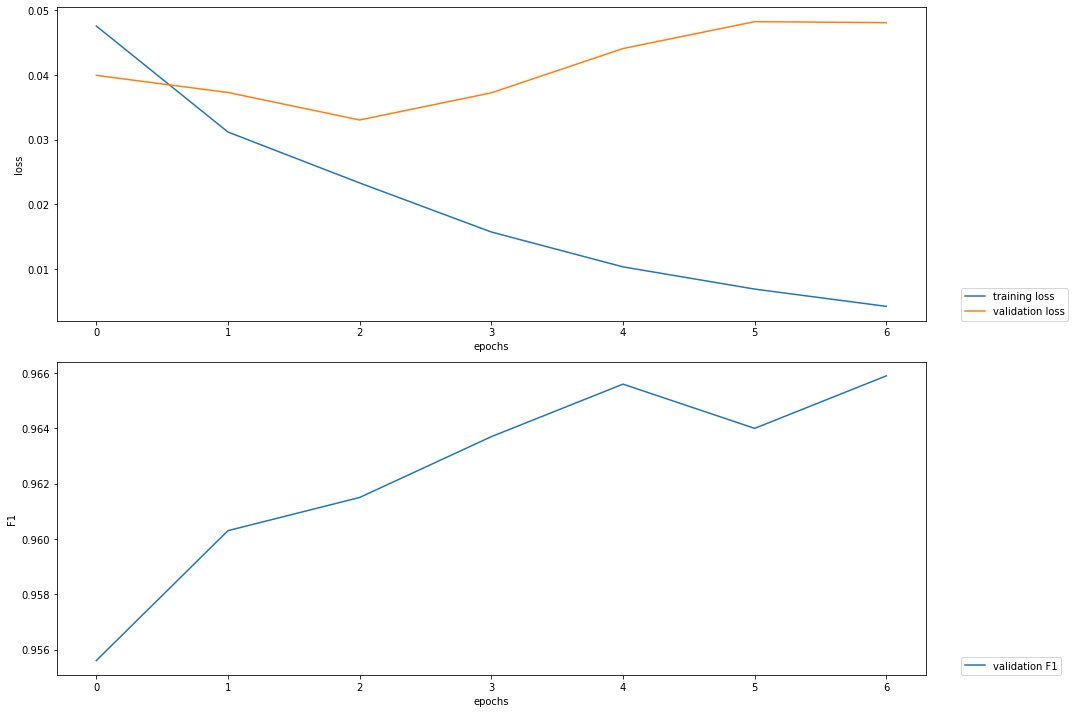

2022-08-24 17:00:46,526 Weights plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/twitter_distilroberta_final/weights.png


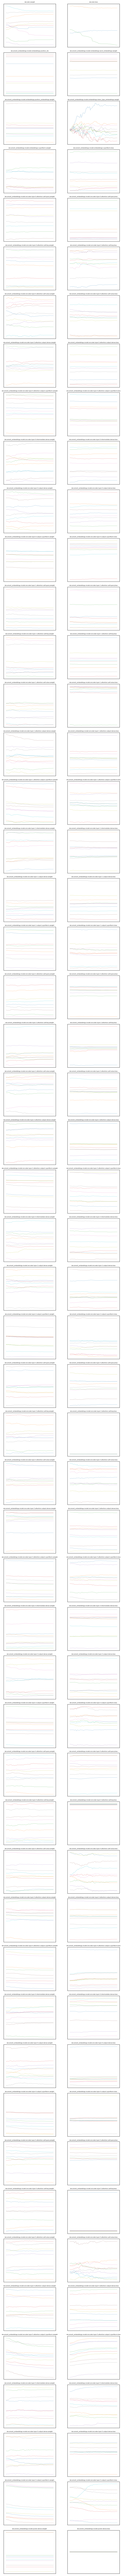

In [17]:
# visualize
plotter = Plotter()
plotter.plot_training_curves(path_model_distilroberta+'/loss.tsv')
plotter.plot_weights(path_model_distilroberta+'/weights.txt')

In [18]:
new_clf = TextClassifier.load(path_model_distilroberta+'/final-model.pt')

2022-08-24 17:00:49,987 loading file /content/drive/My Drive/team project/codes/models/flair_models/twitter_distilroberta_final/final-model.pt


In [19]:
pred1 = Sentence("That girl is stupid")
pred2 = Sentence("This is a good material")

In [20]:
new_clf.predict(pred1)

In [21]:
pred1

Sentence: "That girl is stupid" → __label__1 (0.9979)

In [22]:
pred2

Sentence: "This is a good material"